In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Participants

In [2]:
folder = './data/'
batch = 'batch-2-20p'
filename = '/BIAT_processed_logs_round-02.csv'

df_participants = pd.read_csv(folder+batch+filename, sep=';')
df_participants = df_participants.set_index('participant_id', drop=True)

# anonymize
df_participants.drop("profession", axis=1, inplace=True)
df_participants.drop("country", axis=1, inplace=True)
df_participants.drop("zipcode", axis=1, inplace=True)
df_participants.drop("email", axis=1, inplace=True)

# filter incomplete/invalid datasets
if(batch=='batch-1-20p'):
    invalid = [
        'undefined_1567130075447', # missing climate change data
        'undefined_1567022177109' # incomplete
    ]
elif(batch=='batch-2-20p'):
    invalid = [
        'undefined_1567784779482',
        'undefined_1567783320446',
        'undefined_1567784038416'
#         'undefined_1567774000263' # missing Progressive/Conservative
    ] 

c = len(df_participants)

df_participants = df_participants.drop(invalid)
print('batch: %s' % batch)
print('%d invalid rows dropped, # of valid participants: %d' % (c-len(df_participants), len(df_participants)))

df_participants.head()

batch: batch-1-20p
2 invalid rows dropped, # of valid participants: 21


,IP,age,gender,pre_study_mode,version,Progressive/Conservative_d_score,Progressive/Conservative_preferred,Progressive/Conservative_magnitude,Progressive/Conservative_dScoreFit,Progressive/Conservative_self_assessment,...,Australian/Multiculturalism_magnitude,Australian/Multiculturalism_dScoreFit,Australian/Multiculturalism_self_assessment,Australian/Multiculturalism_attributeFocalCategoryFit,Australian/Multiculturalism_focalBlacksheep,Australian/Multiculturalism_focal_wishlist,Australian/Multiculturalism_attributeNonfocalCategoryFit,Australian/Multiculturalism_nonfocal_blacksheep,Australian/Multiculturalism_nonfocal_wishlist,Australian/Multiculturalism_comment
participant_id,,,,,,,,,,,,,,,,,,,,,
undefined_1567045888758,2001:8003:2033:1b01:16:33c6:2c20:275c,42,male,True,2.1,0.956788,Progressive,a strong,6.0,2.0,...,a slight,2.0,6.0,3.0,n.a.,n.a.,6.0,n.a.,n.a.,"Again, hard to put some of there as ""bad"""
undefined_1567050708097,NaN,26,male,True,2.1,0.343709,Progressive,a slight,5.0,2.0,...,a strong,5.0,5.0,5.0,na,na,5.0,na,na,NaN
undefined_1567057572780,NaN,36,male,True,2.1,0.920338,Progressive,a strong,7.0,1.0,...,a slight,1.0,7.0,5.0,NaN,Look at Australian/international holidays or e...,4.0,Chace,I was unsure of chance and what connotation it...,"Good test. I just got muddled, my hands wouldn..."
undefined_1567049578552,101.166.233.51,22,male,True,2.1,0.721100,Progressive,a strong,6.0,2.0,...,a moderate,6.0,3.0,6.0,n.a,n.a,5.0,chance,embrace,NaN
undefined_1567045563462,NaN,34,male,True,2.1,0.331548,Progressive,a slight,3.0,1.0,...,a strong,6.0,6.0,7.0,n.a,n.a,7.0,n.a,n.a,It isn't explained that these should be opposi...


## Demographics

In [3]:
rounded_decimals = 2

print('Total: %d participants' % (len(df_participants)))
# # age
participants_age = [age for age in df_participants['age']]
participants_age = np.asarray(participants_age)
print('Mean age: %f (SD=%f), min: %d, max: %d' % (round(participants_age.mean(), rounded_decimals), round(participants_age.std(), rounded_decimals), participants_age.min(), participants_age.max()))

Total: 21 participants
Mean age: 29.000000 (SD=7.390000), min: 18, max: 42


In [4]:
# gender
df_gender = df_participants.groupby(['gender'])
for index, gender in df_gender:
    print(index, len(gender))

female 7
male 14


# BIAT Analysis
1. (dis)agreement between d_score and self assessment
2. prediction accuracy according to the four classification (d_score/self-assessment agreement (focal and non-focal) and false positives/negatives)
3. and an agreement, disagreement, and co-agreement score (based on Vatavu’s metrics) for term suggestions

Based on 3) we refine the attributes and re-run the study to see whether we can increase 1) and 2)

In [5]:
FOCAL = 0
NON_FOCAL = 1

LIKERT_ASSESSMENT_THRESHOLD = 4 # [1, 7]
LIKERT_ASSESSMENT_THRESHOLD_LOW = 3 # [1, 2]
LIKERT_ASSESSMENT_THRESHOLD_HIGH = 5 # [6, 7]

# magnitude thresholds
D_SCORE_THRESHOLD_SLIGHT = 0.15   # [.15, .35], little to no < .15
D_SCORE_THRESHOLD_MODERATE = 0.35 # [.35, .65]
D_SCORE_THRESHOLD_STRONG = 0.65   # >.65

FILTER_D_SCORE_THRESHOLD = True
D_SCORE_THRESHOLD = D_SCORE_THRESHOLD_MODERATE

def get_preference(d_score, categories=['focal', 'non_focal']):
    if (d_score >= 0.0):
        return categories[FOCAL]
    else:
        return categories[NON_FOCAL]
    
# correlation magnitudes
def get_correlation_magnitude(rvalue):
    if(rvalue >=0):
        resultString = 'a positive'
    elif(rvalue):
        resultString = 'a negative'
    else:
        resultString = 'no'

    rvalue = abs(rvalue)
    if(rvalue < .2):
        resultString += ' weak'
    elif(rvalue < .4):
        resultString += ' moderate'
    else:
        resultString += ' strong'
    
    return resultString + ' correlation'

def calculate_accuracy(tp, tn, fp, fn):
    return (tp+tn)/(tp+fp+fn+tn)

## Progressive/Conservative
### d-Score Fit

1 row(s) dropped, total dataset 'Progressive/Conservative': 20
Mean Progressive/Conservative_dScoreFit: 5.250000 (SD=1.520000), median: 5, min: 2, max: 7


[(1, 7)]

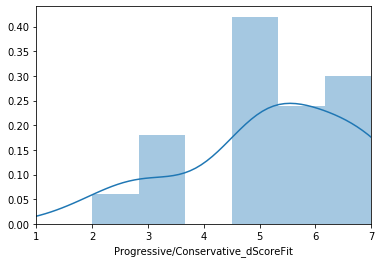

In [6]:
biat = 'Progressive/Conservative'
categories = biat.split('/') # [focal non_focal]

col = biat + '_dScoreFit'
d_score_fit = df_participants[col]

# remove NaNs
c = len(d_score_fit)
d_score_fit = d_score_fit.dropna()
print('%d row(s) dropped, total dataset \'%s\': %d' % (c-len(d_score_fit), biat, len(d_score_fit)))
print('Mean %s: %f (SD=%f), median: %d, min: %d, max: %d' % (col, round(d_score_fit.mean(), rounded_decimals), round(d_score_fit.std(), rounded_decimals), np.median(d_score_fit), d_score_fit.min(), d_score_fit.max()))

figure = sns.distplot(d_score_fit);
figure.set(xlim=(1, 7))

## Correlation: d_score vs. self-assessment

In [7]:
d_scores = df_participants[[biat+'_d_score', biat+'_self_assessment']]
d_scores = d_scores.dropna()
d_scores

,Progressive/Conservative_d_score,Progressive/Conservative_self_assessment
participant_id,,
undefined_1567045888758,0.956788,2.0
undefined_1567050708097,0.343709,2.0
undefined_1567057572780,0.920338,1.0
undefined_1567049578552,0.721100,2.0
undefined_1567045563462,0.331548,1.0
undefined_1567147947358,0.424474,3.0
undefined_1567001255993,0.374745,2.0
undefined_1567060008738,0.762081,5.0
undefined_1567144351735,0.510059,5.0


In [8]:
# filter for thresholds
if(FILTER_D_SCORE_THRESHOLD):    
    d_scores = d_scores[abs(d_scores[biat+'_d_score'])>D_SCORE_THRESHOLD]
    print('Threshold applied: %f, # of data points: %d' % (D_SCORE_THRESHOLD, len(d_scores), ))
else:
    print('No threshold applied, # of data points: %d' % (len(d_scores)))

Threshold applied: 0.350000, # of data points: 14


Pearson correlation: -0.519466, a negative strong correlation (p=0.056944)


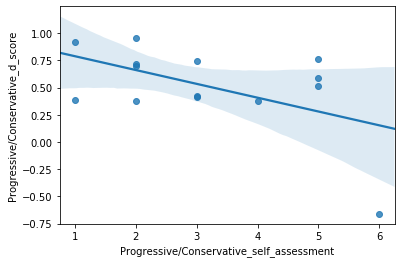

In [9]:
corr, pvalue = pearsonr(d_scores[biat+'_d_score'], d_scores[biat+'_self_assessment'])
# corr = d_scores.corr(method='pearson')
# corr

sns.regplot(y=biat+'_d_score', x=biat+'_self_assessment', data=d_scores);
print('Pearson correlation: %f, %s (p=%f)' % (corr, get_correlation_magnitude(corr),pvalue))

## Focal vs. Non-focal
Four classes (d_score, self_assessment):
- **true focals** (0, 0): participants agreeing with being classified with a focal preference, e.g., a true progressive
- **false focals** (0, 1): participants disagreeing with being classified with a focal preference, e.g., a conservative progressive
- **true non_focals** (1, 1): participants agreeing with being classified with a non_focal preference, e.g., a true conservative
- **false non_focals** (1, 0): participants disagreeing with being classified with a non_focal preference, e.g., a progressive conservative

9 true focals
3 false focals
1 true non_focals
0 false non_focals


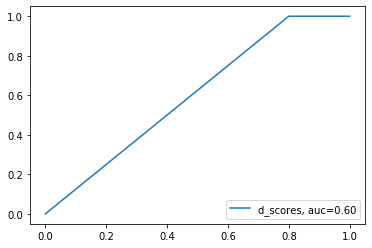


accuracy: 0.71, precision: 0.71 recall: 0.71, f1: 0.71


In [10]:
true_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
false_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
true_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
false_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
print('%d true focals' % (len(true_focals)))
print('%d false focals' % (len(false_focals)))
print('%d true non_focals' % (len(true_non_focals)))
print('%d false non_focals' % (len(false_non_focals)))

d_scores_focal = [(row[1][biat + '_d_score'] > 0) for row in d_scores.iterrows()]
self_assessments_focal = [(row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD) for row in d_scores.iterrows()]

accuracy = accuracy_score(self_assessments_focal, d_scores_focal)
precision = precision_score(self_assessments_focal, d_scores_focal)
recall = recall_score(self_assessments_focal, d_scores_focal)
f1 = f1_score(self_assessments_focal, d_scores_focal)

fpr, tpr, _ = roc_curve(self_assessments_focal,  d_scores_focal)
auc = roc_auc_score(self_assessments_focal, d_scores_focal)
plt.plot(fpr,tpr,label='d_scores, auc={0:0.2f}'.format(auc))
plt.legend(loc=4)
plt.show()

print('')
print('accuracy: {0:0.2f}, precision: {0:0.2f} recall: {0:0.2f}, f1: {0:0.2f}'.format(accuracy, precision, recall, f1))

## Feminism/Anti-feminism
### d-Score Fit

0 row(s) dropped, total dataset 'Feminism/Anti-feminism': 21
Mean Feminism/Anti-feminism_dScoreFit: 5.050000 (SD=1.600000), median: 5, min: 1, max: 7


[(1, 7)]

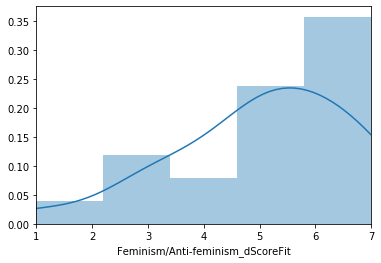

In [11]:
biat = 'Feminism/Anti-feminism'
categories = biat.split('/') # [focal non_focal]

col = biat + '_dScoreFit'
d_score_fit = df_participants[col]

# remove NaNs
c = len(d_score_fit)
d_score_fit = d_score_fit.dropna()
print('%d row(s) dropped, total dataset \'%s\': %d' % (c-len(d_score_fit), biat, len(d_score_fit)))
print('Mean %s: %f (SD=%f), median: %d, min: %d, max: %d' % (col, round(d_score_fit.mean(), rounded_decimals), round(d_score_fit.std(), rounded_decimals), np.median(d_score_fit), d_score_fit.min(), d_score_fit.max()))

figure = sns.distplot(d_score_fit);
figure.set(xlim=(1, 7))

## Correlation: d_score vs. self-assessment

In [12]:
d_scores = df_participants[[biat+'_d_score', biat+'_self_assessment']]
d_scores = d_scores.dropna()
d_scores

,Feminism/Anti-feminism_d_score,Feminism/Anti-feminism_self_assessment
participant_id,,
undefined_1567045888758,0.612189,2
undefined_1567050708097,0.810127,2
undefined_1567057572780,0.314691,1
undefined_1567049578552,-0.162750,3
undefined_1567045563462,0.565674,2
undefined_1567147947358,0.595912,3
undefined_1567001255993,0.703993,2
undefined_1567060008738,-0.155407,5
undefined_1566994900458,0.099048,1


In [13]:
# filter for thresholds
if(FILTER_D_SCORE_THRESHOLD):    
    d_scores = d_scores[abs(d_scores[biat+'_d_score'])>D_SCORE_THRESHOLD]
    print('Threshold applied: %f, # of data points: %d' % (D_SCORE_THRESHOLD, len(d_scores), ))
else:
    print('No threshold applied, # of data points: %d' % (len(d_scores)))

Threshold applied: 0.350000, # of data points: 13


Pearson correlation: -0.425669, a negative strong correlation (p=0.147005)


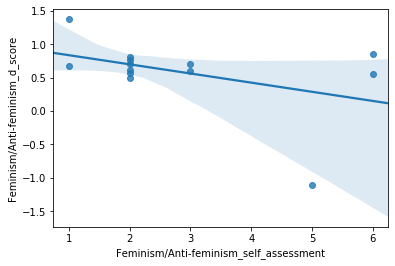

In [14]:
corr, pvalue = pearsonr(d_scores[biat+'_d_score'], d_scores[biat+'_self_assessment'])
# corr = d_scores.corr(method='pearson')
# corr

sns.regplot(y=biat+'_d_score', x=biat+'_self_assessment', data=d_scores);
print('Pearson correlation: %f, %s (p=%f)' % (corr, get_correlation_magnitude(corr),pvalue))

## Focal vs. Non-focal
Four classes (d_score, self_assessment):
- **true focals** (0, 0): participants agreeing with being classified with a focal preference, e.g., a true progressive
- **false focals** (0, 1): participants disagreeing with being classified with a focal preference, e.g., a conservative progressive
- **true non_focals** (1, 1): participants agreeing with being classified with a non_focal preference, e.g., a true conservative
- **false non_focals** (1, 0): participants disagreeing with being classified with a non_focal preference, e.g., a progressive conservative

10 true focals
2 false focals
1 true non_focals
0 false non_focals


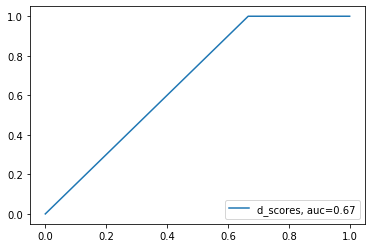


accuracy: 0.85, precision: 0.85 recall: 0.85, f1: 0.85


In [15]:
true_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
false_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
true_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
false_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
print('%d true focals' % (len(true_focals)))
print('%d false focals' % (len(false_focals)))
print('%d true non_focals' % (len(true_non_focals)))
print('%d false non_focals' % (len(false_non_focals)))

d_scores_focal = [(row[1][biat + '_d_score'] > 0) for row in d_scores.iterrows()]
self_assessments_focal = [(row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD) for row in d_scores.iterrows()]

accuracy = accuracy_score(self_assessments_focal, d_scores_focal)
precision = precision_score(self_assessments_focal, d_scores_focal)
recall = recall_score(self_assessments_focal, d_scores_focal)
f1 = f1_score(self_assessments_focal, d_scores_focal)

fpr, tpr, _ = roc_curve(self_assessments_focal,  d_scores_focal)
auc = roc_auc_score(self_assessments_focal, d_scores_focal)
plt.plot(fpr,tpr,label='d_scores, auc={0:0.2f}'.format(auc))
plt.legend(loc=4)
plt.show()

print('')
print('accuracy: {0:0.2f}, precision: {0:0.2f} recall: {0:0.2f}, f1: {0:0.2f}'.format(accuracy, precision, recall, f1))

## Australian/Multiculturalism
### d-Score Fit

0 row(s) dropped, total dataset 'Australian/Multiculturalism': 21
Mean Australian/Multiculturalism_dScoreFit: 4.520000 (SD=1.630000), median: 5, min: 1, max: 7


[(1, 7)]

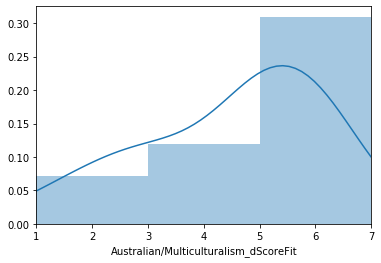

In [16]:
biat = 'Australian/Multiculturalism'
categories = biat.split('/') # [focal non_focal]

col = biat + '_dScoreFit'
d_score_fit = df_participants[col]

# remove NaNs
c = len(d_score_fit)
d_score_fit = d_score_fit.dropna()
print('%d row(s) dropped, total dataset \'%s\': %d' % (c-len(d_score_fit), biat, len(d_score_fit)))
print('Mean %s: %f (SD=%f), median: %d, min: %d, max: %d' % (col, round(d_score_fit.mean(), rounded_decimals), round(d_score_fit.std(), rounded_decimals), np.median(d_score_fit), d_score_fit.min(), d_score_fit.max()))

figure = sns.distplot(d_score_fit);
figure.set(xlim=(1, 7))

## Correlation: d_score vs. self-assessment

In [17]:
d_scores = df_participants[[biat+'_d_score', biat+'_self_assessment']]
d_scores = d_scores.dropna()
d_scores

,Australian/Multiculturalism_d_score,Australian/Multiculturalism_self_assessment
participant_id,,
undefined_1567045888758,0.240354,6.0
undefined_1567050708097,1.179869,5.0
undefined_1567057572780,0.310396,7.0
undefined_1567049578552,0.483934,3.0
undefined_1567045563462,-0.751278,6.0
undefined_1567147947358,-0.767269,6.0
undefined_1567001255993,1.002077,2.0
undefined_1567060008738,-0.165075,5.0
undefined_1566994900458,-0.086961,7.0


In [18]:
# filter for thresholds
if(FILTER_D_SCORE_THRESHOLD):    
    d_scores = d_scores[abs(d_scores[biat+'_d_score'])>D_SCORE_THRESHOLD]
    print('Threshold applied: %f, # of data points: %d' % (D_SCORE_THRESHOLD, len(d_scores), ))
else:
    print('No threshold applied, # of data points: %d' % (len(d_scores)))

Threshold applied: 0.350000, # of data points: 11


Pearson correlation: -0.368978, a negative moderate correlation (p=0.264127)


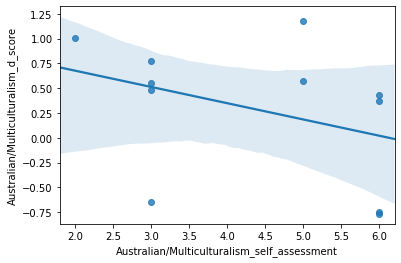

In [19]:
corr, pvalue = pearsonr(d_scores[biat+'_d_score'], d_scores[biat+'_self_assessment'])
# corr = d_scores.corr(method='pearson')
# corr

sns.regplot(y=biat+'_d_score', x=biat+'_self_assessment', data=d_scores);
print('Pearson correlation: %f, %s (p=%f)' % (corr, get_correlation_magnitude(corr),pvalue))

## Focal vs. Non-focal
Four classes (d_score, self_assessment):
- **true focals** (0, 0): participants agreeing with being classified with a focal preference, e.g., a true progressive
- **false focals** (0, 1): participants disagreeing with being classified with a focal preference, e.g., a conservative progressive
- **true non_focals** (1, 1): participants agreeing with being classified with a non_focal preference, e.g., a true conservative
- **false non_focals** (1, 0): participants disagreeing with being classified with a non_focal preference, e.g., a progressive conservative

4 true focals
4 false focals
2 true non_focals
1 false non_focals


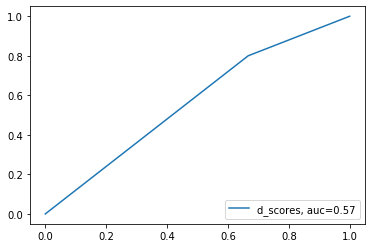


accuracy: 0.55, precision: 0.55 recall: 0.55, f1: 0.55


In [20]:
true_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
false_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
true_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
false_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
print('%d true focals' % (len(true_focals)))
print('%d false focals' % (len(false_focals)))
print('%d true non_focals' % (len(true_non_focals)))
print('%d false non_focals' % (len(false_non_focals)))

d_scores_focal = [(row[1][biat + '_d_score'] > 0) for row in d_scores.iterrows()]
self_assessments_focal = [(row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD) for row in d_scores.iterrows()]

accuracy = accuracy_score(self_assessments_focal, d_scores_focal)
precision = precision_score(self_assessments_focal, d_scores_focal)
recall = recall_score(self_assessments_focal, d_scores_focal)
f1 = f1_score(self_assessments_focal, d_scores_focal)

fpr, tpr, _ = roc_curve(self_assessments_focal,  d_scores_focal)
auc = roc_auc_score(self_assessments_focal, d_scores_focal)
plt.plot(fpr,tpr,label='d_scores, auc={0:0.2f}'.format(auc))
plt.legend(loc=4)
plt.show()

print('')
print('accuracy: {0:0.2f}, precision: {0:0.2f} recall: {0:0.2f}, f1: {0:0.2f}'.format(accuracy, precision, recall, f1))

## Man-made Climate Change/Natural Climate Cycles
### d-Score Fit

0 row(s) dropped, total dataset 'Man-made Climate Change/Natural Climate Cycles': 21
Mean Man-made Climate Change/Natural Climate Cycles_dScoreFit: 4.520000 (SD=1.780000), median: 5, min: 1, max: 7


[(1, 7)]

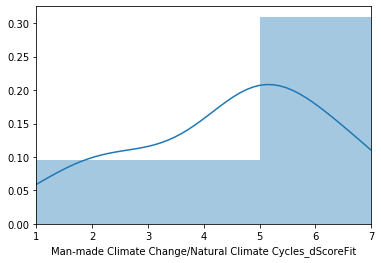

In [21]:
biat = 'Man-made Climate Change/Natural Climate Cycles'
categories = biat.split('/') # [focal non_focal]

col = biat + '_dScoreFit'
d_score_fit = df_participants[col]

# remove NaNs
c = len(d_score_fit)
d_score_fit = d_score_fit.dropna()
print('%d row(s) dropped, total dataset \'%s\': %d' % (c-len(d_score_fit), biat, len(d_score_fit)))
print('Mean %s: %f (SD=%f), median: %d, min: %d, max: %d' % (col, round(d_score_fit.mean(), rounded_decimals), round(d_score_fit.std(), rounded_decimals), np.median(d_score_fit), d_score_fit.min(), d_score_fit.max()))

figure = sns.distplot(d_score_fit);
figure.set(xlim=(1, 7))

## Correlation: d_score vs. self-assessment

In [22]:
d_scores = df_participants[[biat+'_d_score', biat+'_self_assessment']]
d_scores = d_scores.dropna()
d_scores

,Man-made Climate Change/Natural Climate Cycles_d_score,Man-made Climate Change/Natural Climate Cycles_self_assessment
participant_id,,
undefined_1567045888758,0.264546,2.0
undefined_1567050708097,-0.267031,2.0
undefined_1567057572780,0.289214,1.0
undefined_1567049578552,0.851394,3.0
undefined_1567045563462,0.219703,1.0
undefined_1567147947358,-0.084107,3.0
undefined_1567001255993,0.820270,1.0
undefined_1567060008738,0.268046,3.0
undefined_1566994900458,-0.259362,1.0


In [23]:
# filter for thresholds
if(FILTER_D_SCORE_THRESHOLD):    
    d_scores = d_scores[abs(d_scores[biat+'_d_score'])>D_SCORE_THRESHOLD]
    print('Threshold applied: %f, # of data points: %d' % (D_SCORE_THRESHOLD, len(d_scores), ))
else:
    print('No threshold applied, # of data points: %d' % (len(d_scores)))

Threshold applied: 0.350000, # of data points: 8


Pearson correlation: -0.599732, a negative strong correlation (p=0.116046)


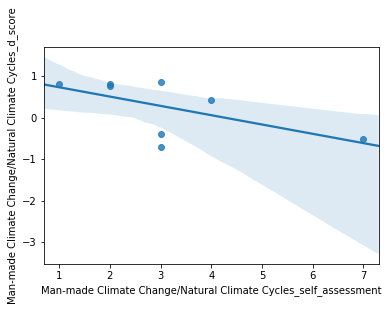

In [24]:
corr, pvalue = pearsonr(d_scores[biat+'_d_score'], d_scores[biat+'_self_assessment'])
# corr = d_scores.corr(method='pearson')
# corr

sns.regplot(y=biat+'_d_score', x=biat+'_self_assessment', data=d_scores);
print('Pearson correlation: %f, %s (p=%f)' % (corr, get_correlation_magnitude(corr),pvalue))

## Focal vs. Non-focal
Four classes (d_score, self_assessment):
- **true focals** (0, 0): participants agreeing with being classified with a focal preference, e.g., a true progressive
- **false focals** (0, 1): participants disagreeing with being classified with a focal preference, e.g., a conservative progressive
- **true non_focals** (1, 1): participants agreeing with being classified with a non_focal preference, e.g., a true conservative
- **false non_focals** (1, 0): participants disagreeing with being classified with a non_focal preference, e.g., a progressive conservative

4 true focals
0 false focals
1 true non_focals
2 false non_focals


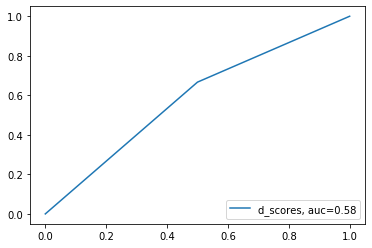


accuracy: 0.62, precision: 0.62 recall: 0.62, f1: 0.62


In [25]:
true_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
false_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']>0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
true_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] > LIKERT_ASSESSMENT_THRESHOLD]
false_non_focals = [row for row in d_scores.iterrows() if row[1][biat + '_d_score']<0 and row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD]
print('%d true focals' % (len(true_focals)))
print('%d false focals' % (len(false_focals)))
print('%d true non_focals' % (len(true_non_focals)))
print('%d false non_focals' % (len(false_non_focals)))

d_scores_focal = [(row[1][biat + '_d_score'] > 0) for row in d_scores.iterrows()]
self_assessments_focal = [(row[1][biat + '_self_assessment'] < LIKERT_ASSESSMENT_THRESHOLD) for row in d_scores.iterrows()]

accuracy = accuracy_score(self_assessments_focal, d_scores_focal)
precision = precision_score(self_assessments_focal, d_scores_focal)
recall = recall_score(self_assessments_focal, d_scores_focal)
f1 = f1_score(self_assessments_focal, d_scores_focal)

fpr, tpr, _ = roc_curve(self_assessments_focal,  d_scores_focal)
auc = roc_auc_score(self_assessments_focal, d_scores_focal)
plt.plot(fpr,tpr,label='d_scores, auc={0:0.2f}'.format(auc))
plt.legend(loc=4)
plt.show()

print('')
print('accuracy: {0:0.2f}, precision: {0:0.2f} recall: {0:0.2f}, f1: {0:0.2f}'.format(accuracy, precision, recall, f1))

### Further Analysis

In [26]:
# compare d_score_fits across BIATs in whisker plots: sns.despine(offset=10, trim=True)

# BIAT Attributes

In [27]:
# compare fit